# Ensamble de modelos

## Importar librerías útiles

In [2]:
# Librerías estándar
import pandas as pd
import numpy as np
import itertools

# Librerías de Ciencia de Datos
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics         import confusion_matrix
from sklearn.metrics         import roc_curve
from sklearn.metrics         import roc_auc_score
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.dummy           import DummyClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.pipeline        import Pipeline
from sklearn.svm             import SVC
from sklearn.tree            import DecisionTreeClassifier
from sklearn.preprocessing   import StandardScaler

# Librerías de visualización
import seaborn as sns
import matplotlib.pyplot as plt

# Otras librerías
import warnings
warnings.simplefilter('ignore')

plt.style.use('ggplot')

%matplotlib inline

In [3]:
# Definir semilla para poder reproducir resultados
SEED = 12345

In [4]:
# Definir funciones útiles
def grafica_matriz_confusion(cm, classes=[0,1], normalize=False, title='Matriz de confusión\n', cmap=plt.cm.Reds):
    """ 
    Función para mostrar la matriz de confusión de un problema de clasificación binario. 
    El parámetro cm puede ser el objeto resultante de ejecutar la función confusion_matrix() de la librería sklearn.
    
    Args:
        cm         matriz de confusión de sklearn
        classes    categorías de la variable target
        normalize  normaliza asignando el parámetro True
        title      string para definir el título para la gráfica
        cmap       mapa de colores
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max()
    text = [["VN =", "FN ="], ["FP =", "VP ="]]
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "     {}".format(round (cm[i, j],2)), horizontalalignment="left",
                 color="white" if cm[i, j] > thresh else "black")
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, text[j][i] , horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Valor real')
    plt.xlabel('Predicción')
    
def grafica_curva_roc(fpr, tpr, title='Curva ROC', note=''):
    """
    Función para graficar la curva ROC
    Los parámetros fpr y tpr son el output de ejecutar la función roc_curve de sklearn
    
    Args:
        fpr        Tasa de falsos positivos 
        tpr        Tasa de verdaderos positivos
        title      sting para definir el título de la gráfica
        note       Nota para mostrar en la gráfica
    """
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('Tasa de falsos positivos ')
    plt.ylabel('Tasa de verdaderos positivos')
    plt.title(title)
    if note: plt.text(0.6, 0.2, note)
    plt.show()

## Importar set de datos

In [5]:
from sklearn.datasets import make_moons, make_gaussian_quantiles
from sklearn.model_selection import train_test_split

X_moons, y_moons = make_moons(1000, noise=0.2, random_state=SEED)

## Gráfica los datos

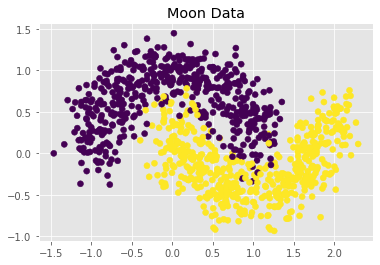

In [6]:
plt.scatter(X_moons[:,0], X_moons[:,1], c=y_moons)
plt.title('Moon Data')
plt.show()

## Partir el set de datos en train y test

In [7]:
# Partición de datos
X_train, X_test, y_train, y_test = train_test_split(X_moons, y_moons, test_size = 0.3, random_state = SEED)
# Comprueba que se hayan partido correctamente
print("X_train represents {0:.2f}% of the data set".format(X_train.shape[0]/X_moons.shape[0]*100))
print("X_test  represents {0:.2f}% of the data set".format(X_test.shape[0]/X_moons.shape[0]*100))

X_train represents 70.00% of the data set
X_test  represents 30.00% of the data set


## Entrena tres modelos de aprendizaje de máquina

### Regresión logística con norma L2 como término regularizador
  * 3-Fold CV estratificado
  * utiliza un pipeline de Python para entrenar tu modelo
  * hyper parámetro C puede tomar valores en: logspace 10^-5 to 10^5
  * usa la métrica de efectividad
  * usa la función de Sklearn llamada `validation_curve()`. Investiga de qué trata
  * asigna el valor -1 a `n_jobs` para usar todos los cores del CPU disponibles para entrenar el modelo
  * utiliza la semilla definida en la parte de arriba para poder reproducir los resultados

In [8]:
# Utiliza el siguiente espacio para los valores que puede tomar el hyper parámetro C
C_values = np.logspace(-4, 6, 10, base = 10)

In [9]:
# 3-Fold CV
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED, shuffle = True)
N_JOBS = -1

# Define un pipeline con toda la información del modelo
estimators = []
estimators.append(('logit_model_l2', LogisticRegression()))
pipeline = Pipeline(estimators)
pipeline.set_params(logit_model_l2__penalty='l2')
pipeline.set_params(logit_model_l2__random_state = SEED)
pipeline.set_params(logit_model_l2__solver = 'lbfgs')
pipeline.set_params(logit_model_l2__n_jobs = N_JOBS)
pipeline

# Utiliza la función validation_curve para entrenar y validar varios modelos (tantos como valores para el hyper parámetro C)
train_scores, test_scores = validation_curve(pipeline, X_train, y_train, 
                                              param_name = 'logit_model_l2__C', 
                                              param_range  = C_values, 
                                              cv = cv_schema, scoring = 'accuracy', n_jobs = N_JOBS)


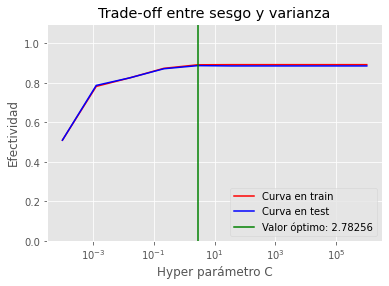

In [10]:
# Gráfica los resultados para todos los valores del hyper parámetro C
# Saca el promedio de los resultados obtenidos en la parte de arriba
train_scores_mean_cv = np.mean(train_scores, axis = 1)
test_scores_mean_cv = np.mean(test_scores, axis = 1)

# Escoge el valor de C tal que:
# Maximice la efectividad en el test de validación
# Minimice la diferencia entre la métrica de efectividad en el set de datos de entrenamiento y validación
choose_index_list = list(np.array(test_scores_mean_cv) - np.abs((np.array(train_scores_mean_cv)-np.array(test_scores_mean_cv))))
choose_index = choose_index_list.index(np.max(choose_index_list))

# Guarda el valor óptimo para C
optimum_parameter = C_values[choose_index]

# Gráfica las curvas de efectividad en el set de datos de train y test
import matplotlib.lines as mlines
def plot_score_metric_train_test(SM_list_train, SM_list_test, param_range,choose_index, value_parameter, symbol_parameter):
    plt.plot(param_range, SM_list_train, color = 'r')
    plt.plot(param_range, SM_list_test, 'b')
    plt.axvline(x = optimum_parameter, color = 'g')
    plt.title('Trade-off entre sesgo y varianza')
    plt.xlabel('Hyper parámetro {0}'.format(symbol_parameter))
    plt.ylabel('Efectividad')
    plt.ylim(0.0, 1.1)
    plt.xscale('log')

    train = mlines.Line2D([], [], color='r', marker='',
                              markersize=15, label='Curva en train')
    test = mlines.Line2D([], [], color='b', marker='',
                              markersize=15, label='Curva en test')
    opt_value = mlines.Line2D([], [], color='g', marker='',
                              markersize=15, label='Valor óptimo: {0:.5f}'.format(value_parameter))
    plt.legend(handles=[train, test, opt_value])
    plt.show()
    
# Gráfica las curvas de performance en cada set de datos
plot_score_metric_train_test(train_scores_mean_cv, test_scores_mean_cv, C_values,choose_index, optimum_parameter, 'C')

In [11]:
# Imprime el mejor valor para C
print("Valor óptimo para C es: {0:.5f}".format(optimum_parameter))

Valor óptimo para C es: 2.78256


In [12]:
# Imprime las métricas de efectividad en train y test para cada valor de C
def print_cv_validation_scores(parameter, train_accu_mean_scores, test_accu_mean_scores): 
    dash = '-' * 100
    print(dash)
    print('{:<30s}{:<35s}{:<25s}'.format('Valor de Hyper parámetro','Efectividad media en train', 'Efectividad media en test'))
    print(dash)
    for i in range(len(parameter)):
        print('{:<30.4f}{:<35.3f}{:<25.3f}'.format(parameter[i], train_accu_mean_scores[i], test_accu_mean_scores[i]))
    print(dash)

print_cv_validation_scores(C_values, train_scores_mean_cv, test_scores_mean_cv)

----------------------------------------------------------------------------------------------------
Valor de Hyper parámetro      Efectividad media en train         Efectividad media en test
----------------------------------------------------------------------------------------------------
0.0001                        0.510                              0.510                    
0.0013                        0.782                              0.787                    
0.0167                        0.826                              0.826                    
0.2154                        0.874                              0.871                    
2.7826                        0.891                              0.887                    
35.9381                       0.892                              0.886                    
464.1589                      0.892                              0.886                    
5994.8425                     0.892                              0.886

In [13]:
# Entrena un modelo final con el hyper parámetro C óptimo
pipeline.set_params(logit_model_l2__C = optimum_parameter)
logit_model_l2 = pipeline.named_steps['logit_model_l2'] 
logit_model_l2.fit(X_train,y_train)
accu_logit_model_l2 = logit_model_l2.score(X_test,y_test)
print ("Efectividad del modelo: {0:.2f}%".format(100*accu_logit_model_l2))

Efectividad del modelo: 88.00%


In [14]:
# Haz una predicción
y_pred_logit = logit_model_l2.predict(X_test)
y_pred_proba_logit = logit_model_l2.predict_proba(X_test)

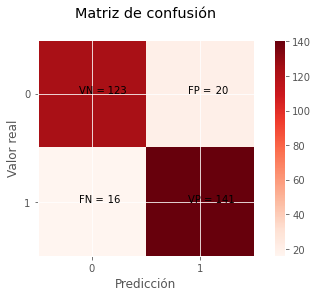

In [15]:
# Muestra la matriz de confusión
matriz_confusion_logit = confusion_matrix(y_test, y_pred_logit)  
grafica_matriz_confusion(matriz_confusion_logit)

In [16]:
# Cuántos errores cometimos?
error_logit = matriz_confusion_logit[0][1] + matriz_confusion_logit[1][0]
print('# Errores =', error_logit)
print('% Erroress =', error_logit/len(y_pred_logit))

# Errores = 36
% Erroress = 0.12


In [17]:
# Calcula la efectividad
efectividad_logit = matriz_confusion_logit[0][0] + matriz_confusion_logit[1][1]
print('# Aciertos =', efectividad_logit)
print('% Efectividad =', efectividad_logit/len(y_pred_logit))
print('Otra forma de calcular la efectividad =', 1-(error_logit/len(y_pred_logit)))

# Aciertos = 264
% Efectividad = 0.88
Otra forma de calcular la efectividad = 0.88


In [18]:
# Calcula el recall y la precisión de la predicción
recall_logit = matriz_confusion_logit[1][1]/(matriz_confusion_logit[1][1] + matriz_confusion_logit[1][0])
precision_logit = matriz_confusion_logit[1][1]/(matriz_confusion_logit[1][1] + matriz_confusion_logit[0][1])
print('% Recall =', recall_logit)
print('% Precisión =', precision_logit)

% Recall = 0.8980891719745223
% Precisión = 0.8757763975155279


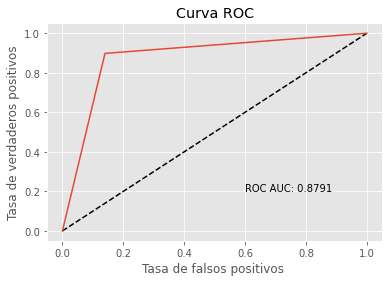

In [19]:
# Calcula la tasa de falsos positivos y la tasa de verdaderos positivos para poder graficar la curva ROC, y para calcular la métrica ROC AUC
fpr_logit, tpr_logit, _ = roc_curve(y_test, y_pred_logit)
auc_logit = roc_auc_score(y_test, y_pred_logit)
grafica_curva_roc(fpr_logit, tpr_logit, 'Curva ROC', note='ROC AUC: {0:.4f}'.format(auc_logit))

### Clasificador KNN
  * 3-Fold CV estratificado
  * utiliza un pipeline de Python para entrenar tu modelo
  * hyper parámetro K puede tomar valores en: [1,10]
  * usa la métrica de efectividad
  * usa la función de Sklearn llamada `validation_curve()`. Investiga de qué trata
  * asigna el valor -1 a `n_jobs` para usar todos los cores del CPU disponibles para entrenar el modelo
  * utiliza la semilla definida en la parte de arriba para poder reproducir los resultados

In [20]:
# Utiliza el siguiente espacio para los valores que puede tomar el hyper parámetro K
K_values  = np.array([int(i) for i in np.linspace(1, 15,15)])

In [21]:
# Utiliza un clasificador KNN
N_JOBS = -1
model     = KNeighborsClassifier(n_jobs = N_JOBS)
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED, shuffle=True)

# Define un pipeline con toda la información del modelo
estimators = []
estimators.append(('knn', model))
pipeline = Pipeline(estimators) 
pipeline.set_params(knn__n_jobs = N_JOBS)
pipeline

# Utiliza la función validation_curve para entrenar y validar varios modelos (tantos como valores para el hyper parámetro K)

train_scores, test_scores = validation_curve(pipeline, X_train, y_train, 
                                              param_name = 'knn__n_neighbors', 
                                              param_range  = K_values, 
                                              cv = cv_schema, scoring = 'accuracy', n_jobs = N_JOBS)

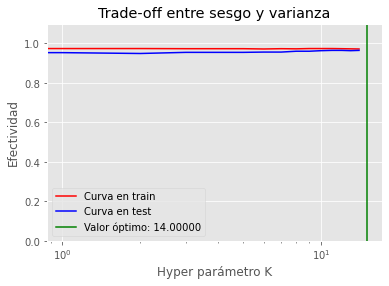

In [22]:
# Gráfica los resultados para todos los valores del hyper parámetro K
# Saca el promedio de los resultados obtenidos en la parte de arriba
train_scores_mean_cv = np.mean(train_scores, axis = 1)
test_scores_mean_cv = np.mean(test_scores, axis = 1)

# Escoge el valor de K tal que:
# Maximice la efectividad en el test de validación
# Minimice la diferencia entre la métrica de efectividad en el set de datos de entrenamiento y validación
choose_index_list = list(np.array(test_scores_mean_cv) - np.abs((np.array(train_scores_mean_cv)-np.array(test_scores_mean_cv))))
choose_index = choose_index_list.index(np.max(choose_index_list))

# Guarda el valor óptimo para K
optimum_parameter = K_values[choose_index]

# Gráfica las curvas de efectividad en el set de datos de train y test
import matplotlib.lines as mlines
def plot_score_metric_train_test(SM_list_train, SM_list_test,choose_index, value_parameter, symbol_parameter):
    plt.plot(SM_list_train, color = 'r')
    plt.plot(SM_list_test, 'b')
    plt.axvline(x = optimum_parameter, color = 'g')
    plt.title('Trade-off entre sesgo y varianza')
    plt.xlabel('Hyper parámetro {0}'.format(symbol_parameter))
    plt.ylabel('Efectividad')
    plt.ylim(0.0, 1.1)
    plt.xscale('log')

    train = mlines.Line2D([], [], color='r', marker='',
                              markersize=15, label='Curva en train')
    test = mlines.Line2D([], [], color='b', marker='',
                              markersize=15, label='Curva en test')
    opt_value = mlines.Line2D([], [], color='g', marker='',
                              markersize=15, label='Valor óptimo: {0:.5f}'.format(value_parameter))
    plt.legend(handles=[train, test, opt_value])
    plt.show()
    
# Gráfica las curvas de performance en cada set de datos
plot_score_metric_train_test(train_scores_mean_cv,test_scores_mean_cv, K_values, choose_index, 'K')

In [23]:
# Imprime el mejor valor para C
print("Valor óptimo para K es: {0:.5f}".format(optimum_parameter))

Valor óptimo para K es: 15.00000


In [24]:
# Imprime las métricas de efectividad en train y test para cada valor de K
print_cv_validation_scores(K_values, train_scores_mean_cv, test_scores_mean_cv)

----------------------------------------------------------------------------------------------------
Valor de Hyper parámetro      Efectividad media en train         Efectividad media en test
----------------------------------------------------------------------------------------------------
1.0000                        1.000                              0.949                    
2.0000                        0.974                              0.953                    
3.0000                        0.974                              0.949                    
4.0000                        0.973                              0.954                    
5.0000                        0.973                              0.954                    
6.0000                        0.973                              0.954                    
7.0000                        0.971                              0.956                    
8.0000                        0.973                              0.956

In [25]:
# Entrena un modelo final con el hyper parámetro K óptimo
pipeline.set_params(knn__n_neighbors = optimum_parameter)
knn = pipeline.named_steps['knn'] 
knn.fit(X_train,y_train)
accu_knn = knn.score(X_test,y_test)
print ("Efectividad del modelo: {0:.2f}%".format(100*accu_knn))

Efectividad del modelo: 96.33%


In [26]:
# Haz una predicción
y_pred_knn = knn.predict(X_test)
y_pred_proba_knn = knn.predict_proba(X_test)

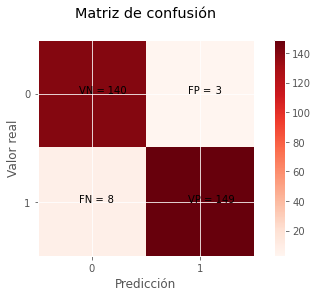

In [27]:
# Muestra la matriz de confusión
matriz_confusion_knn = confusion_matrix(y_test, y_pred_knn)  
grafica_matriz_confusion(matriz_confusion_knn)

In [28]:
# Cuántos errores cometimos?
error_knn = matriz_confusion_knn[0][1] + matriz_confusion_knn[1][0]
print('# Errores =', error_knn)
print('% Erroress =', error_knn/len(y_pred_knn))

# Errores = 11
% Erroress = 0.03666666666666667


In [29]:
# Calcula la efectividad
efectividad_knn = matriz_confusion_knn[0][0] + matriz_confusion_knn[1][1]
print('# Aciertos =', efectividad_knn)
print('% Efectividad =', efectividad_knn/len(y_pred_knn))
print('Otra forma de calcular la efectividad =', 1-(error_knn/len(y_pred_knn)))

# Aciertos = 289
% Efectividad = 0.9633333333333334
Otra forma de calcular la efectividad = 0.9633333333333334


In [30]:
# Calcula el recall y la precisión de la predicción
recall_knn = matriz_confusion_knn[1][1]/(matriz_confusion_knn[1][1] + matriz_confusion_knn[1][0])
precision_knn = matriz_confusion_knn[1][1]/(matriz_confusion_knn[1][1] + matriz_confusion_knn[0][1])
print('% Recall =', recall_knn)
print('% Precisión =', precision_knn)

% Recall = 0.9490445859872612
% Precisión = 0.9802631578947368


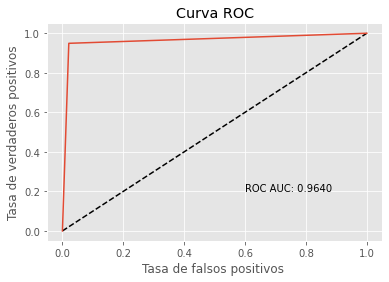

In [31]:
# Calcula la tasa de falsos positivos y la tasa de verdaderos positivos para poder graficar la curva ROC, y para calcular la métrica ROC AUC
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_knn)
auc_knn = roc_auc_score(y_test, y_pred_knn)
grafica_curva_roc(fpr_knn, tpr_knn, 'Curva ROC', note='ROC AUC: {0:.4f}'.format(auc_knn))

### Modelo Árbol de decisión
  * 3-Fold CV estratificado
  * utiliza un pipeline de Python para entrenar tu modelo
  * hyper parámetro max_depth puede tomar valores en: linspace(1,10,10)
  * usa la métrica de efectividad
  * usa la función de Sklearn llamada `validation_curve()`. Investiga de qué trata
  * utiliza la semilla definida en la parte de arriba para poder reproducir los resultados

In [32]:
# Utiliza el siguiente espacio para los valores que puede tomar el hyper parámetro C
max_depth = np.linspace(1,10,10)

In [33]:
# 3-Fold CV
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED, shuffle=True)

# Define un pipeline con toda la información del modelo
estimators = []
estimators.append(('tree', DecisionTreeClassifier()))
pipeline = Pipeline(estimators) 
pipeline.set_params(tree__criterion='gini')
pipeline.set_params(tree__random_state = SEED)
pipeline.set_params(tree__splitter='best')
pipeline

# Utiliza la función validation_curve para entrenar y validar varios modelos (tantos como valores para el hyper parámetro C)
train_scores, test_scores = validation_curve(pipeline, X_train, y_train, 
                                              param_name = 'tree__max_depth', 
                                              param_range  = max_depth, 
                                              cv = cv_schema, scoring = 'accuracy')


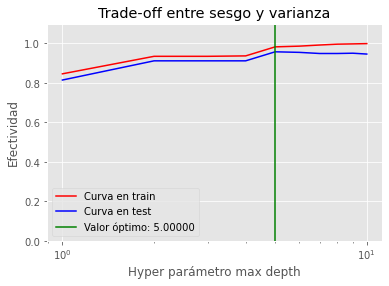

In [34]:
# Gráfica los resultados para todos los valores del hyper parámetro max_depth
# Saca el promedio de los resultados obtenidos en la parte de arriba
train_scores_mean_cv = np.mean(train_scores, axis = 1)
test_scores_mean_cv = np.mean(test_scores, axis = 1)

# Escoge el valor de max_depth tal que:
# Maximice la efectividad en el test de validación
# Minimice la diferencia entre la métrica de efectividad en el set de datos de entrenamiento y validación
choose_index_list = list(np.array(test_scores_mean_cv) - np.abs((np.array(train_scores_mean_cv)-np.array(test_scores_mean_cv))))
choose_index = choose_index_list.index(np.max(choose_index_list))

# Guarda el valor óptimo para max_depth
optimum_parameter = max_depth[choose_index]

# Gráfica las curvas de efectividad en el set de datos de train y test
import matplotlib.lines as mlines
def plot_score_metric_train_test(SM_list_train, SM_list_test, param_range,choose_index, value_parameter, symbol_parameter):
    plt.plot(param_range, SM_list_train, color = 'r')
    plt.plot(param_range, SM_list_test, 'b')
    plt.axvline(x = optimum_parameter, color = 'g')
    plt.title('Trade-off entre sesgo y varianza')
    plt.xlabel('Hyper parámetro {0}'.format(symbol_parameter))
    plt.ylabel('Efectividad')
    plt.ylim(0.0, 1.1)
    plt.xscale('log')

    train = mlines.Line2D([], [], color='r', marker='',
                              markersize=15, label='Curva en train')
    test = mlines.Line2D([], [], color='b', marker='',
                              markersize=15, label='Curva en test')
    opt_value = mlines.Line2D([], [], color='g', marker='',
                              markersize=15, label='Valor óptimo: {0:.5f}'.format(value_parameter))
    plt.legend(handles=[train, test, opt_value])
    plt.show()
    
# Gráfica las curvas de performance en cada set de datos
plot_score_metric_train_test(train_scores_mean_cv, test_scores_mean_cv, max_depth,choose_index, optimum_parameter, 'max depth')

In [35]:
# Imprime el mejor valor para max_depth
print("Valor óptimo para max_depth es: {0:.5f}".format(optimum_parameter))

Valor óptimo para max_depth es: 5.00000


In [36]:
# Imprime las métricas de efectividad en train y test para cada valor de max_depth
def print_cv_validation_scores(parameter, train_accu_mean_scores, test_accu_mean_scores): 
    dash = '-' * 100
    print(dash)
    print('{:<30s}{:<35s}{:<25s}'.format('Valor de Hyper parámetro','Efectividad media en train', 'Efectividad media en test'))
    print(dash)
    for i in range(len(parameter)):
        print('{:<30.4f}{:<35.3f}{:<25.3f}'.format(parameter[i], train_accu_mean_scores[i], test_accu_mean_scores[i]))
    print(dash)

print_cv_validation_scores(max_depth, train_scores_mean_cv, test_scores_mean_cv)

----------------------------------------------------------------------------------------------------
Valor de Hyper parámetro      Efectividad media en train         Efectividad media en test
----------------------------------------------------------------------------------------------------
1.0000                        0.846                              0.814                    
2.0000                        0.934                              0.911                    
3.0000                        0.934                              0.911                    
4.0000                        0.936                              0.911                    
5.0000                        0.982                              0.957                    
6.0000                        0.986                              0.954                    
7.0000                        0.991                              0.949                    
8.0000                        0.996                              0.949

In [37]:
# Entrena un modelo final con el hyper parámetro C óptimo
pipeline.set_params(tree__max_depth = optimum_parameter)
tree = pipeline.named_steps['tree'] 
tree.fit(X_train,y_train)
accu_tree = tree.score(X_test,y_test)
print ("Efectividad del modelo: {0:.2f}%".format(100*accu_tree))

Efectividad del modelo: 94.33%


In [38]:
# Haz una predicción
y_pred_tree = tree.predict(X_test)
y_pred_proba_tree = tree.predict_proba(X_test)

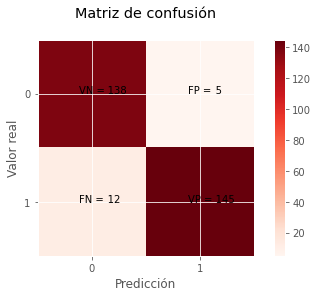

In [39]:
# Muestra la matriz de confusión
matriz_confusion_tree = confusion_matrix(y_test, y_pred_tree)  
grafica_matriz_confusion(matriz_confusion_tree)

In [40]:
# Cuántos errores cometimos?
error_tree = matriz_confusion_tree[0][1] + matriz_confusion_tree[1][0]
print('# Errores =', error_tree)
print('% Erroress =', error_tree/len(y_pred_tree))

# Errores = 17
% Erroress = 0.056666666666666664


In [41]:
# Calcula la efectividad
efectividad_tree = matriz_confusion_tree[0][0] + matriz_confusion_tree[1][1]
print('# Aciertos =', efectividad_tree)
print('% Efectividad =', efectividad_tree/len(y_pred_tree))
print('Otra forma de calcular la efectividad =', 1-(error_tree/len(y_pred_tree)))

# Aciertos = 283
% Efectividad = 0.9433333333333334
Otra forma de calcular la efectividad = 0.9433333333333334


In [42]:
# Calcula el recall y la precisión de la predicción
recall_tree = matriz_confusion_tree[1][1]/(matriz_confusion_tree[1][1] + matriz_confusion_tree[1][0])
precision_tree = matriz_confusion_tree[1][1]/(matriz_confusion_tree[1][1] + matriz_confusion_tree[0][1])
print('% Recall =', recall_tree)
print('% Precisión =', precision_tree)

% Recall = 0.9235668789808917
% Precisión = 0.9666666666666667


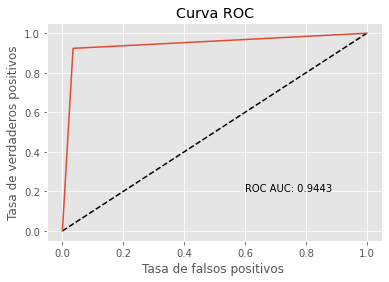

In [43]:
# Calcula la tasa de falsos positivos y la tasa de verdaderos positivos para poder graficar la curva ROC, y para calcular la métrica ROC AUC
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_pred_tree)
auc_tree = roc_auc_score(y_test, y_pred_tree)
grafica_curva_roc(fpr_tree, tpr_tree, 'Curva ROC', note='ROC AUC: {0:.4f}'.format(auc_tree))

## Compara los modelos

In [44]:
classifiers = ['logit_model_l2', 'knn', 'tree']
accuracy = [efectividad_logit/len(y_pred_logit), efectividad_knn/len(y_pred_knn), efectividad_tree/len(y_pred_tree)]
roc_auc = [auc_logit, auc_knn, auc_tree]
recall = [recall_logit, recall_knn, recall_tree]
precision = [precision_logit, precision_knn, precision_tree]

In [45]:
## Compara las métricas de los modelos anteriores
def print_metrics(classifier_name, metric_1_list, metric_2_list, metric_3_list, metric_4_list): 
    dash = '-' * 80
    print(dash)
    print('{:<20s}{:<15s}{:<15s}{:<15s}{:<15s}'.format('Clasificador','Efectividad', 'ROC AUC', 'recall', 'precision'))
    print(dash)
    for i in range(len(classifier_name)):
        print('{:<20s}{:<15.3f}{:<15.3f}{:<15.3f}{:<15.3f}'.format(classifier_name[i], metric_1_list[i], metric_2_list[i], metric_3_list[i], metric_4_list[i]))
    print(dash)
    
print_metrics(classifiers, accuracy, roc_auc, recall, precision)

--------------------------------------------------------------------------------
Clasificador        Efectividad    ROC AUC        recall         precision      
--------------------------------------------------------------------------------
logit_model_l2      0.880          0.879          0.898          0.876          
knn                 0.963          0.964          0.949          0.980          
tree                0.943          0.944          0.924          0.967          
--------------------------------------------------------------------------------


## Entrena un ensamble de modelos

Ensamble de modelos.
* Utiliza el objeto llamado VotingClassifier de Sklearn
* Utiliza los 3 modelos anteriores (los que entrenaste utilizando el parámetro óptimo)

In [46]:
from sklearn.ensemble import VotingClassifier

voting_classifier = VotingClassifier(
    estimators=[('Log Reg', logit_model_l2), ('KNN', knn), ('tree',tree)], voting='hard'
                )
voting_classifier.fit(X_train, y_train)
print ("Efectividad del modelo: {0:.2f}%".format(100*voting_classifier.score(X_test, y_test)))

Efectividad del modelo: 95.33%


In [47]:
# Haz una predicción
y_pred_voting_classifier = voting_classifier.predict(X_test)

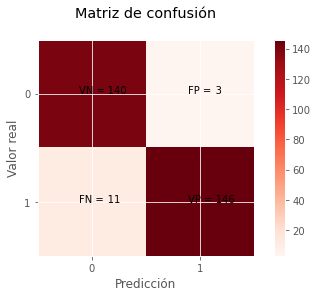

In [48]:
# Muestra la matriz de confusión
matriz_confusion_voting_classifier = confusion_matrix(y_test, y_pred_voting_classifier)  
grafica_matriz_confusion(matriz_confusion_voting_classifier)

In [49]:
# Cuántos errores cometimos?
error_voting_classifier = matriz_confusion_voting_classifier[0][1] + matriz_confusion_voting_classifier[1][0]
print('# Errores =', error_voting_classifier)
print('% Erroress =', error_voting_classifier/len(y_pred_voting_classifier))

# Errores = 14
% Erroress = 0.04666666666666667


In [50]:
# Calcula la efectividad
efectividad_voting_classifier = matriz_confusion_voting_classifier[0][0] + matriz_confusion_voting_classifier[1][1]
print('# Aciertos =', efectividad_voting_classifier)
print('% Efectividad =', efectividad_voting_classifier/len(y_pred_voting_classifier))
print('Otra forma de calcular la efectividad =', 1-(error_voting_classifier/len(y_pred_voting_classifier)))

# Aciertos = 286
% Efectividad = 0.9533333333333334
Otra forma de calcular la efectividad = 0.9533333333333334


In [51]:
# Calcula el recall y la precisión de la predicción
recall_voting_classifier = matriz_confusion_voting_classifier[1][1]/(matriz_confusion_voting_classifier[1][1] + matriz_confusion_voting_classifier[1][0])
precision_voting_classifier = matriz_confusion_voting_classifier[1][1]/(matriz_confusion_voting_classifier[1][1] + matriz_confusion_voting_classifier[0][1])
print('% Recall =', recall_voting_classifier)
print('% Precisión =', precision_voting_classifier)

% Recall = 0.9299363057324841
% Precisión = 0.9798657718120806


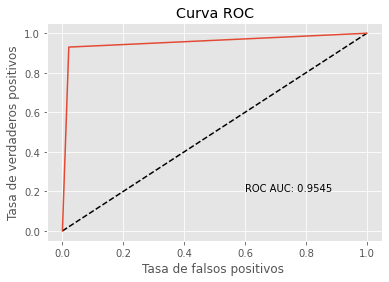

In [52]:
# Calcula la tasa de falsos positivos y la tasa de verdaderos positivos para poder graficar la curva ROC, y para calcular la métrica ROC AUC
fpr_voting_classifier, tpr_voting_classifier, _ = roc_curve(y_test, y_pred_voting_classifier)
auc_voting_classifier = roc_auc_score(y_test, y_pred_voting_classifier)
grafica_curva_roc(fpr_voting_classifier, tpr_voting_classifier, 'Curva ROC', note='ROC AUC: {0:.4f}'.format(auc_voting_classifier))

## Compara los modelos nuevamente

In [53]:
# Agrega las métricas del modelo ensamble
classifiers = ['logit_model_l2', 'knn', 'tree', 'ensamble']
accuracy = [efectividad_logit/len(y_pred_logit), efectividad_knn/len(y_pred_knn), efectividad_tree/len(y_pred_tree), efectividad_voting_classifier/len(y_pred_voting_classifier)]
roc_auc = [auc_logit, auc_knn, auc_tree, auc_voting_classifier]
recall = [recall_logit, recall_knn, recall_tree, recall_voting_classifier]
precision = [precision_logit, precision_knn, precision_tree, precision_voting_classifier]

# Imprime tabla de resultados
print_metrics(classifiers, accuracy, roc_auc, recall, precision)

--------------------------------------------------------------------------------
Clasificador        Efectividad    ROC AUC        recall         precision      
--------------------------------------------------------------------------------
logit_model_l2      0.880          0.879          0.898          0.876          
knn                 0.963          0.964          0.949          0.980          
tree                0.943          0.944          0.924          0.967          
ensamble            0.953          0.954          0.930          0.980          
--------------------------------------------------------------------------------


## Bootstrap para seleccionar el modelo ganador

In [54]:
num_records = y_moons.shape[0]
bootstrap_errors_logit_model_l2 = []
bootstrap_errors_knn = []
bootstrap_errors_tree = []
bootstrap_errors_ensamble = []
for i in range(1000):
    train_indices = np.random.choice(range(num_records), num_records, replace=True)
    test_indices = np.setdiff1d(range(num_records), train_indices)
    X_train_b, y_train_b = X_moons[train_indices], y_moons[train_indices]
    X_test_b, y_test_b = X_moons[test_indices], y_moons[test_indices]
    
    # Logit model L2
    logit_model_l2.fit(X_train_b, y_train_b)
    bootstrap_errors_logit_model_l2.append(roc_auc_score(y_test_b, logit_model_l2.predict(X_test_b)))
    
    # Knn model
    knn.fit(X_train_b, y_train_b)
    bootstrap_errors_knn.append(roc_auc_score(y_test_b, knn.predict(X_test_b)))
    
    # Decision trees model
    tree.fit(X_train_b, y_train_b)
    bootstrap_errors_tree.append(roc_auc_score(y_test_b, tree.predict(X_test_b)))
    
    # Ensamble model
    voting_classifier.fit(X_train_b, y_train_b)
    bootstrap_errors_ensamble.append(roc_auc_score(y_test_b, voting_classifier.predict(X_test_b)))
    
bootstrap_errors_sorted_logit_model_l2 = np.sort(bootstrap_errors_logit_model_l2)
bootstrap_errors_sorted_knn = np.sort(bootstrap_errors_knn)
bootstrap_errors_sorted_tree = np.sort(bootstrap_errors_tree)
bootstrap_errors_sorted_ensamble = np.sort(bootstrap_errors_ensamble)

mean_error_knn = bootstrap_errors_sorted_knn.mean()
mean_error_logit_model_l2 = bootstrap_errors_sorted_logit_model_l2.mean()
mean_error_tree = bootstrap_errors_sorted_tree.mean()
mean_error_ensamble = bootstrap_errors_sorted_ensamble.mean()

errors = [mean_error_knn, mean_error_logit_model_l2, mean_error_tree, mean_error_ensamble]

deviation_knn = bootstrap_errors_sorted_knn - mean_error_knn
deviation_logit_model_l2 = bootstrap_errors_sorted_logit_model_l2 - mean_error_logit_model_l2
deviation_tree = bootstrap_errors_sorted_tree - mean_error_tree
deviation_ensamble = bootstrap_errors_sorted_ensamble - mean_error_ensamble

print('95% CIs')
print('Knn: [{:f}, {:f}], con media: {:f}'.format(bootstrap_errors_sorted_knn[25], bootstrap_errors_sorted_knn[975], mean_error_knn))
print('logit_model_l2: [{:f}, {:f}], con media: {:f}'.format(bootstrap_errors_sorted_logit_model_l2[25], bootstrap_errors_sorted_logit_model_l2[975], mean_error_logit_model_l2))
print('Tree: [{:f}, {:f}], con media: {:f}'.format(bootstrap_errors_sorted_tree[25], bootstrap_errors_sorted_tree[975], mean_error_tree))
print('Ensamble: [{:f}, {:f}], con media: {:f}'.format(bootstrap_errors_sorted_ensamble[25], bootstrap_errors_sorted_ensamble[975], mean_error_ensamble))

95% CIs
Knn: [0.943663, 0.978019], con media: 0.961475
logit_model_l2: [0.856675, 0.909217], con media: 0.884008
Tree: [0.922655, 0.971546, con media: 0.949487]
Ensamble: [0.929585, 0.976019, con media: 0.955947]


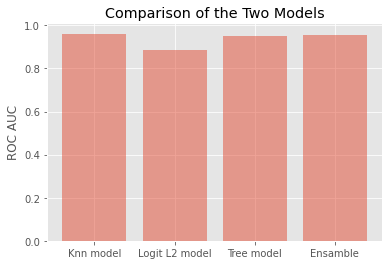

In [55]:
# grafica resultados
xpos = np.arange(len(errors))
plt.bar(xpos, errors, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.xticks(xpos, ('Knn model', 'Logit L2 model', 'Tree model', 'Ensamble'))
plt.ylabel('ROC AUC')
plt.title('Comparison of the Models')
plt.show()

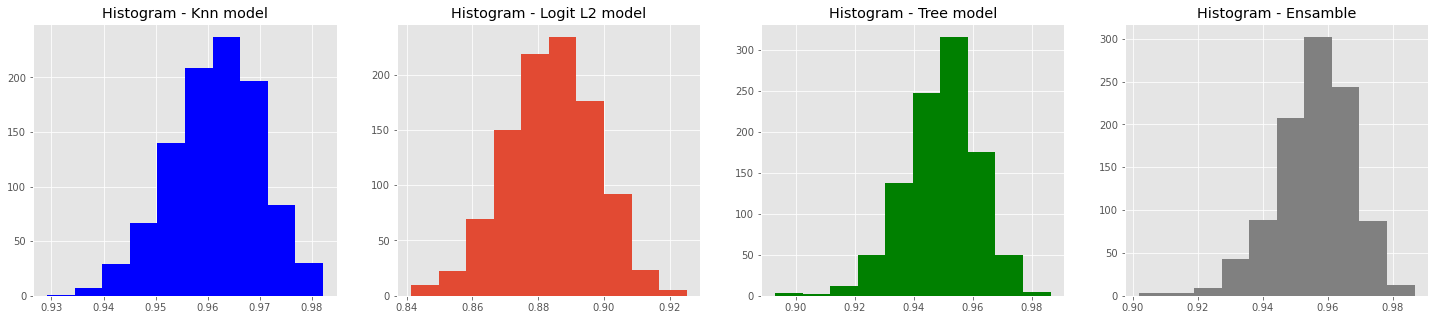

In [56]:
# Checa si los resultados tienen una distribución simétrica
fig, ax = plt.subplots(1,4,figsize=(25,5))
ax[0].hist(bootstrap_errors_sorted_knn, color = 'b')
ax[0].set_title("Histogram - {}".format('Knn model'))

ax[1].hist(bootstrap_errors_sorted_logit_model_l2)
ax[1].set_title("Histogram - {}".format('Logit L2 model'))

ax[2].hist(bootstrap_errors_sorted_tree, color = 'green')
ax[2].set_title("Histogram - {}".format('Tree model'))

ax[3].hist(bootstrap_errors_sorted_ensamble, color = 'gray')
ax[3].set_title("Histogram - {}".format('Ensamble'))
plt.show()